In [559]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [560]:
# raw values of gain and offset for each channel
GAIN_CH0 = 1843252.0855343048
GAIN_CH1 = 1872501.4373586383
GAIN_CH2 = 1848654.547552344

OFFSET_CH0 = 8383140.43862641
OFFSET_CH1 = 8401034.901094487
OFFSET_CH2 = 8382671.373877345

TIMER_MAX = 2**24
TIMER_FREQ = 1e6

In [561]:
def import_24bit_data(fn):
    table = pd.read_csv(fn, sep=',', skiprows = 0)
    table.columns = np.arange(0,422,1)
    
    data_ch0 = []
    for i in range(len(table[0])):
        for j in range(60):
            data_ch0.append(table[j][i])
            
    data_ch1 = []
    for i in range(len(table[60])):
        for j in range(60):
            data_ch1.append(table[60 + j][i])
            
    data_ch2 = []
    for i in range(len(table[120])):
        for j in range(60):
            data_ch2.append(table[120 +j][i])
            
    clock_ticks = []
    for i in range(len(table[360])):
        for j in range(60):
            clock_ticks.append(table[360+j][i])

    data_ch0 = np.array(data_ch0)
    data_ch1 = np.array(data_ch1)
    data_ch2 = np.array(data_ch2)
    clock_ticks = np.array(clock_ticks)
    times_1 = np.array(table[420])
    times_2 = np.array(table[421])

    clock_float = clock_ticks.astype(float)

    clock_ticks_diff = []
    for i in range(len(clock_ticks) - 1):
        diff = clock_float[i+1] - clock_float[i]
        if diff > 0:
            clock_ticks_diff.append(diff)

    clock_rate = 10**6
    
    #clock_ticks_diff = [clock_float[i+1] - clock_float[i] for i in range(len(clock_ticks)-1)]
    print("NUMBER OF DATA POINTS:", len(data_ch1))
    print("MEAN CLOCK TICK DIFF:", np.mean(clock_ticks_diff))
    print("MEAN PERIOD:", np.mean(clock_ticks_diff)/(clock_rate))
    print("MEAN FREQ (Hz):", 1/(np.mean(clock_ticks_diff)/(clock_rate)))
        
    return data_ch0, data_ch1, data_ch2, clock_ticks, times_1, times_2, 1/(np.mean(clock_ticks_diff)/clock_rate)

    

In [562]:
fn = r"C:\Users\natal\Accelerometer_data\20250721T161324_cgem_accel\20250721T161324_FILE0001_cgem_accel.csv" #replace file path
data_ch0, data_ch1, data_ch2, clock_ticks, times1, times2, mean_freq = import_24bit_data(fn)

NUMBER OF DATA POINTS: 543420
MEAN CLOCK TICK DIFF: 1226.9105966611744
MEAN PERIOD: 0.0012269105966611744
MEAN FREQ (Hz): 815.0553126864562


In [563]:
accel_ch0 = (data_ch0 - OFFSET_CH0) / GAIN_CH0
accel_ch1 = (data_ch1 - OFFSET_CH1) / GAIN_CH1
accel_ch2 = (data_ch2 - OFFSET_CH2) / GAIN_CH2
total_accel = np.sqrt((accel_ch0)**2 + (accel_ch1)**2 + (accel_ch2)**2)

In [564]:
#accel_ch0 = accel_ch0[10000:15000]
#accel_ch1 = accel_ch1[10000:15000]
#accel_ch2 = accel_ch2[10000:15000]

In [565]:
print('Average Acceleration (g):')
print(f'x: ', np.mean(accel_ch0))
print(f'y:', np.mean(accel_ch1))
print(f'z:', np.mean(accel_ch2))
print('total average magnitude:', np.mean(total_accel))

std_x = np.std(accel_ch0) / np.sqrt(len(accel_ch0))
std_y = np.std(accel_ch1) / np.sqrt(len(accel_ch1))
std_z = np.std(accel_ch2) / np.sqrt(len(accel_ch2))

print('Standard Deviation (g):')
print(f'x: ', std_x)
print(f'y:', std_y)
print(f'z:', std_z)


Average Acceleration (g):
x:  -0.0553064869835037
y: 0.02547679073977543
z: 0.2534574342639596
total average magnitude: 1.0004735500070514
Standard Deviation (g):
x:  0.0007071285033535494
y: 0.000667796788010231
z: 0.0008782039685575802


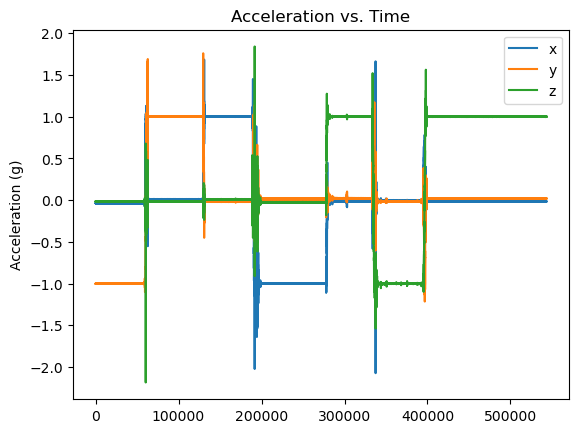

In [566]:
plt.title("Acceleration vs. Time")
plt.plot(accel_ch0, label = "x")
plt.plot(accel_ch1, label = "y")
plt.plot(accel_ch2, label = "z")
plt.ylabel("Acceleration (g)")
plt.legend()

Text(0, 0.5, 'Acceleration (g)')

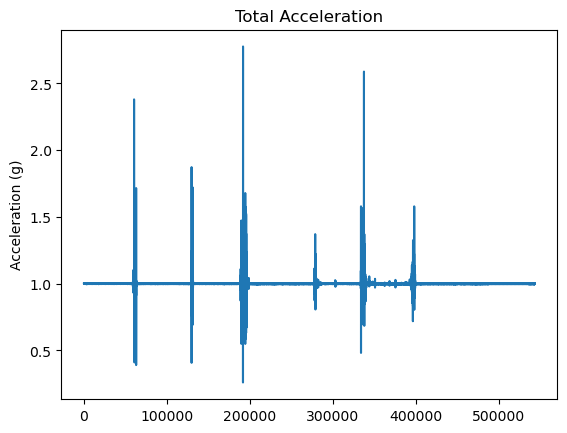

In [567]:
plt.title("Total Acceleration")
plt.plot(total_accel)
plt.ylabel("Acceleration (g)")

In [568]:
# Acceleration FFTs
def accel_fft(accel_ch, sampling_rate, ch_str):
    N = len(accel_ch)
    s = np.fft.fft(accel_ch - accel_ch.mean())
    freqs = np.fft.fftfreq(len(accel_ch), d=1/sampling_rate)

    positive_freqs = freqs[:len(accel_ch) // 2]
    A_fft = np.abs(s[:len(accel_ch) // 2]) / (N / 2)

    # Plot frequencies
    plt.plot(positive_freqs, A_fft)
    plt.title(f"{ch_str} FFT")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Acceleration magnitude (g)")
    plt.xscale('log')
    plt.yscale('log')

    plt.axvline(60, c='red', label='60Hz', alpha=0.4)
    plt.axvline(120, c='blue', label='120Hz', alpha=0.4)
    plt.axvline(180, c='green', label='180Hz', alpha=0.4)
    plt.axvline(1.15, c='black', label='1.2Hz', alpha=0.4)
    plt.legend()
    plt.show()

    return A_fft, positive_freqs

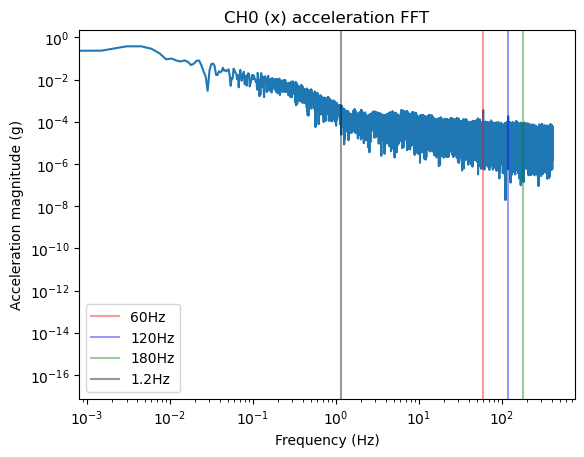

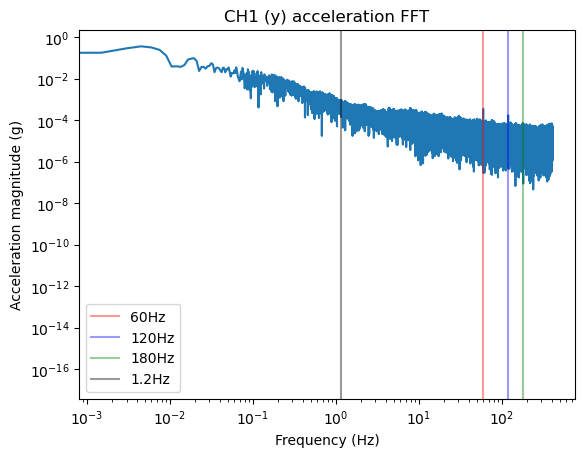

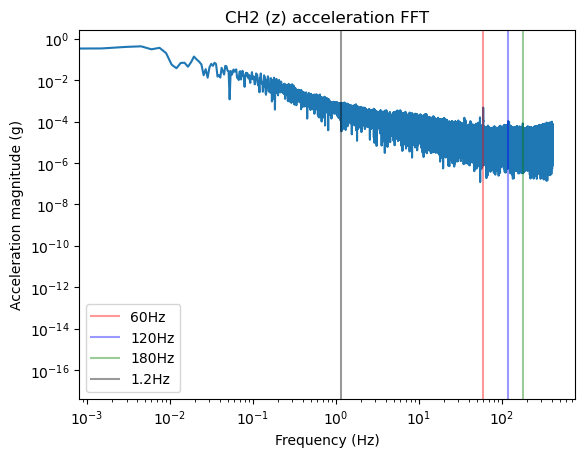

In [569]:
A_fft_ch0, freqs_ch0 = accel_fft(accel_ch0, mean_freq, "CH0 (x) acceleration")
A_fft_ch1, freqs_ch1 = accel_fft(accel_ch1, mean_freq, "CH1 (y) acceleration")
A_fft_ch2, freqs_ch2 = accel_fft(accel_ch2, mean_freq, "CH2 (z) acceleration")

In [570]:
def displacement_fft(A_fft, positive_freqs, ch_str):
    # Assume A_signal_g and positive_freqs are already defined
    A_ms2 = A_fft * 9.81  # convert g to m/s^2
    #k = np.ones(100) / 100
    #A_ms2 = np.convolve(A_ms2, k, mode = "same")

    w = positive_freqs * np.pi * 2
    A_displacement = A_ms2[1:] / w[1:]**2

    # Create the figure and the first axis (for displacement)
    fig, ax1 = plt.subplots()
    plt.legend()
    
    ax1.axvline(30, c='green', label = "30 Hz")
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    #ax1.set_xlim(1, 450)
    ax1.set_xlabel("Frequency (Hz)")
    ax1.set_ylabel("Displacement amplitude (m)", color='b')
    ax1.plot(positive_freqs[1:], A_displacement, 'b-', label='Displacement')
    ax1.tick_params(axis='y', labelcolor='b')

    # Add vertical lines on ax1
    for f in [60, 120, 180]:
        ax1.axvline(f, c='k', alpha=0.4)

    #ax1.axhline(0.005)
    #ax1.axhline(0.025 * 9.81)
    # Create second y-axis for acceleration in g
    ax2 = ax1.twinx()
    ax2.set_yscale('log')
    #ax2.set_ylim(1e-5, 0.3)
    ax2.set_ylabel("Acceleration amplitude (m / s^2)", color='r')
    ax2.plot(positive_freqs, A_ms2, 'r', label='Acceleration (m / s^2)')
    ax2.tick_params(axis='y', labelcolor='r')

    plt.title(f"{ch_str} Acceleration and Displacement")
    plt.tight_layout()
    plt.show()

C:\Users\natal\AppData\Local\Temp\ipykernel_15596\1919710038.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


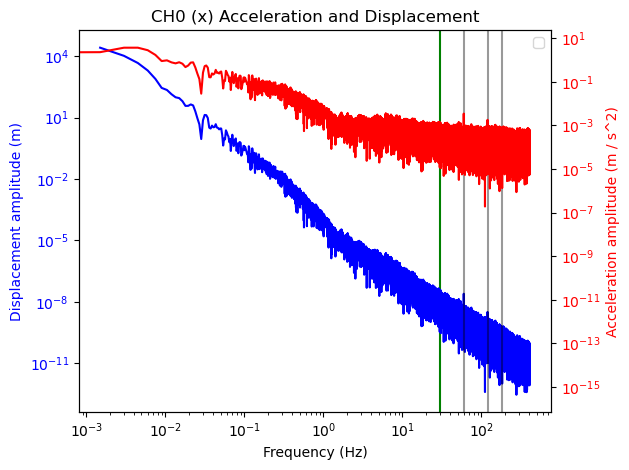

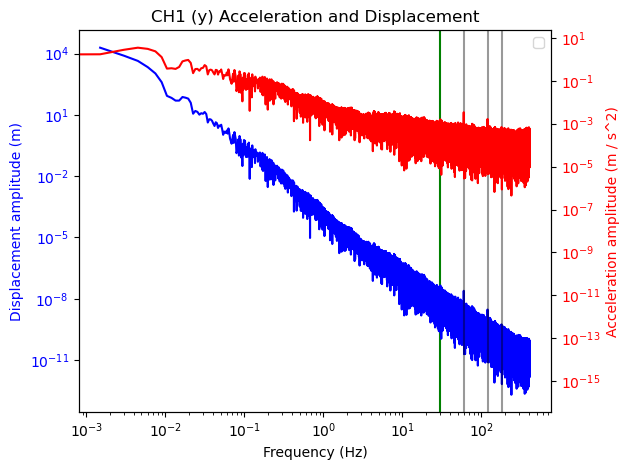

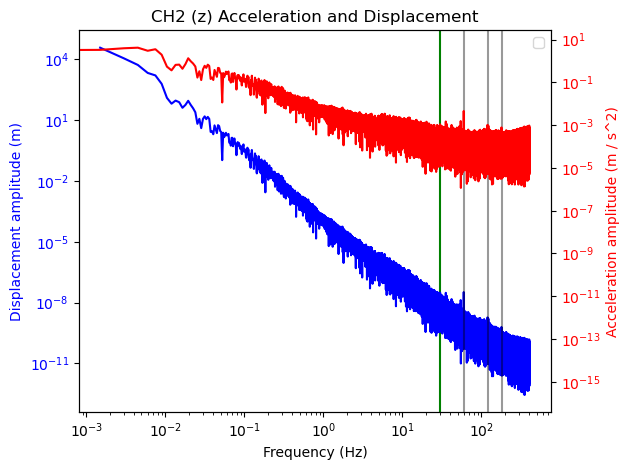

In [571]:
displacement_fft(A_fft_ch0, freqs_ch0, "CH0 (x)")
displacement_fft(A_fft_ch1, freqs_ch1, "CH1 (y)")
displacement_fft(A_fft_ch2, freqs_ch2, "CH2 (z)")

In [572]:
def spectral_density(A_fft, positive_freqs, ch_str):
    sd = A_fft / np.sqrt((positive_freqs[43]-positive_freqs[42]))
    plt.plot(positive_freqs, sd, alpha = 0.2)
    plt.title(f"Noise Spectral Density of {ch_str}")
    plt.xlabel("frequency (Hz)")
    plt.ylabel(r"Noise Spectral Density $\frac{\text{g}}{\sqrt{Hz}}$")
    plt.yscale("log")
    plt.xscale("log")
    k = np.ones(250) / 250
    plt.axhline(7e-4, label = r'$7 \times 10^{-4}$ $\frac{\text{g}}{\sqrt{Hz}}$', color = 'green')
    sd2 = np.convolve(sd, k, mode = "same")
    plt.plot(positive_freqs, sd2)
    plt.xlim(10, 450)
    plt.ylim(1e-7,1e-3)
    plt.legend()

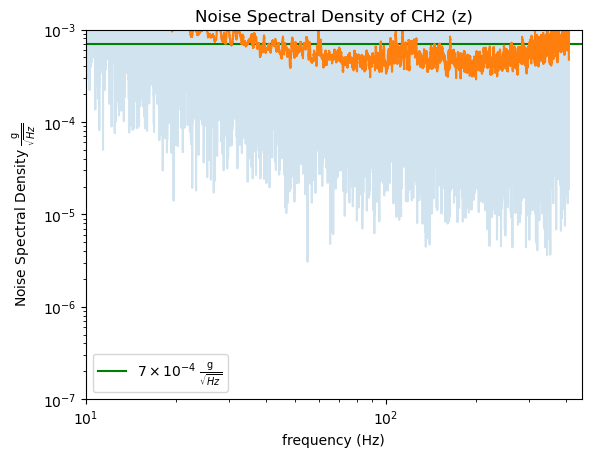

In [573]:
spectral_density(A_fft_ch2, freqs_ch2, "CH2 (z)")

In [574]:
print(len(accel_ch2))

543420


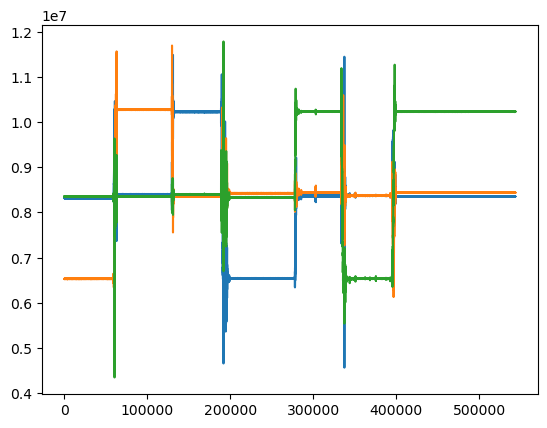

In [575]:
plt.plot(data_ch0)
plt.plot(data_ch1)
plt.plot(data_ch2)

Text(0.5, 1.0, '1 g')

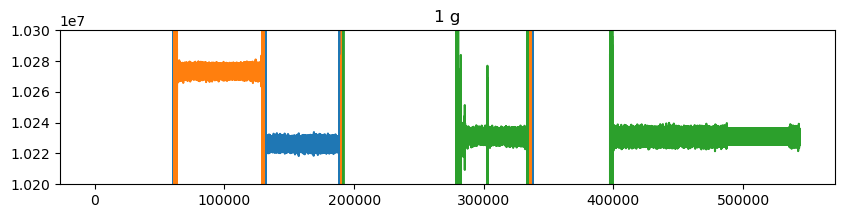

In [576]:
plt.figure(figsize=(10, 2))
plt.plot(data_ch0)
plt.plot(data_ch1)
plt.plot(data_ch2)
plt.ylim(1.02e7, 1.03e7)
plt.title("1 g")

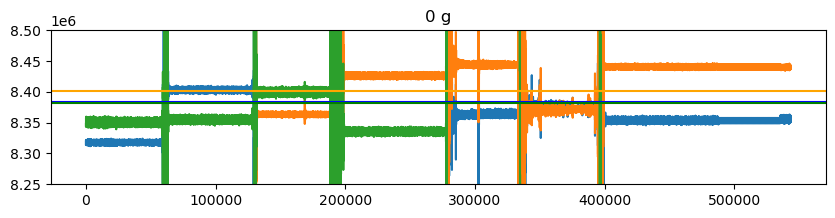

In [600]:
plt.figure(figsize=(10, 2))
plt.plot(data_ch0)
plt.plot(data_ch1)
plt.plot(data_ch2)
plt.ylim(0.825e7, 0.85e7)
plt.title("0 g")
plt.axhline(OFFSET_CH0, color = 'blue')
plt.axhline(OFFSET_CH1, color = 'orange')
plt.axhline(OFFSET_CH2, color = 'green')

Text(0.5, 1.0, '-1 g')

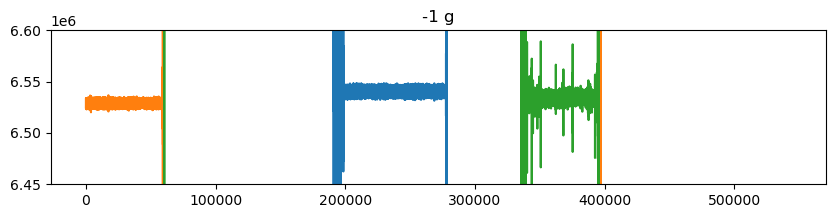

In [578]:
plt.figure(figsize=(10, 2))
plt.plot(data_ch0)
plt.plot(data_ch1)
plt.plot(data_ch2)
plt.ylim(0.645e7, 0.66e7)
plt.title("-1 g")